In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
from xmitgcm import open_mdsdataset

from osse import *
from sloped_MITgcm import *
from canyon_utils import *
from wmt import *

#### Constant parameters

In [43]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = dx
delta_t = 15.

#### Plot WMTs

In [8]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"

ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
ds = ds.sel(time=ds['time'][-1])
#ds = ds.isel(time=[-2, -1]) # COMMENT OUT IN PRODUCTION
ds = add_thalweg(ds)

extend_multiples = [-5, 1]
Lx = dx*ds.XC.size
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds, grid = add_rotated_coords(ds, θ)

ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']
ds['θ'] = ds['θ'].where(ds['hFacC'] != 0)
ds = add_temp_budget(ds, grid, Γ, θ)
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')

ds['days'] = ds['time'].astype('float64')/(86400.*1e9) - 1250.

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


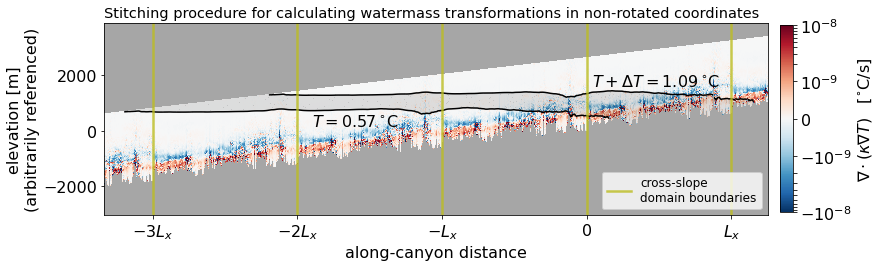

In [97]:
fig = plt.figure(figsize=(12,4))

plt.subplot(facecolor=nancol)
T0 = ΔT+0.05
ΔT = Lx*Γ*np.sin(θ)
pc1 = (ds['diff_tendency_TH']/ds["dV"]).isel(YC=46).plot(x="Xr", y="Zr", norm=matplotlib.colors.SymLogNorm(vmin=-1.e-8, vmax=1e-8, linthresh=1e-9, linscale=0.6))
pc1.colorbar.remove()
T = ds['θ'].isel(YC=46)
pc2 = T.where(np.logical_and(T>=T0, T<=(T0+ΔT))).plot(colors="k", alpha=0.1, levels=[T0, T0+ΔT], x="Xr", y="Zr")
pc2.colorbar.remove()
T.plot.contour(colors="k", levels=[T0, T0+ΔT], x="Xr", y="Zr")
plt.xticks([-3*Lx, -2*Lx, -Lx, 0, Lx, 2*Lx], [r"$-3L_{x}$", r"$-2L_{x}$", r"$-L_{x}$", r"$0$", r"$L_{x}$", r"$2L_{x}$"]);
plt.xlim(-1.6e6, 0.6e6)
plt.title("")
plt.title("Stitching procedure for calculating watermass transformations in non-rotated coordinates", loc="left", fontsize=14.5)
plt.annotate(text=fr"$T={{{round(T0, 2)}}}\,^{{\circ}}$C", xy=(-1.9*Lx, 150))
plt.annotate(text=fr"$T+ΔT={{{round(T0+ΔT, 2)}}}\,^{{\circ}}$C", xy=(0.04*Lx, 1600))

for extend_copy in np.arange(-3, 2):
    plt.axvline(extend_copy*Lx, color="C8", lw=2.5, alpha=0.8)
plt.plot([], [], label="cross-slope\ndomain boundaries", color="C8", lw=2.5, alpha=0.8)
plt.legend(loc="lower right", fontsize=12)
    
plt.xlabel("along-canyon distance")
plt.ylabel("elevation [m]\n(arbitrarily referenced)")
plt.tight_layout()

fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.915, 0.225, 0.015, 0.65])
fig.colorbar(pc1, cax=cbar_ax, label=r"$\nabla \cdot (\kappa \nabla T)\;$  [$^{\circ}$C/s]")
plt.savefig("../../figures/BBTRE/watermass_transformation_section.png", bbox_inches="tight", dpi=200.)